# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

#### 1.2.0 Information:
---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
<b>
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
<b>
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}

### 1.3 Packages and helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import pickle
import pdb
import datetime
import warnings

from scipy.stats import pearsonr
from scipy.stats import boxcox, yeojohnson

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from prettytable import PrettyTable
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DS_FRAC = .25
NF = 7

### 1.4 Importing data

In [3]:
df = pd.read_csv('BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE)
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS


(729174, 10)

In [4]:
# copy a data frame
dfc = df.copy()

In [5]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,577264100.0,white
2013400,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,100000000.0,white
2704440,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,299950000.0,white
1650833,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,299000000.0,white
1586811,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,40000000.0,white


In [6]:
remove_words = ["princeton","padua","montreal"]
for r in remove_words:
    dfc['label']=dfc['label'].str.replace(r,"")
    df['label']=df['label'].str.replace(r,"")

For each time window extending back from the t_now, we take a sample of addresses 

In [7]:
#time_windows = [30,60,90,120,240] # time windows to train on extending back from t_now. t_back[i] = t_now - t_win[i]
#address_samps = [250,500,1000]

In [8]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File containts {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File containts 729174 rows and 10 columns


In [9]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [10]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [11]:
top_ransomwares_dict = dict(dfc.label.value_counts().head(10)[1:])
top10_ransoms_labels = dfc.label.value_counts()[1:11]
top10_ransoms_labels

CryptoWall      3008
CryptoLocker    2322
Cerber          2209
Locky           1628
CryptXXX         617
NoobCrypt        101
DMALockerv3       93
DMALocker         50
SamSam            16
Globe             11
Name: label, dtype: int64

- Note that the data is highly unbalanced

In [12]:
print('The data is over 95% unbalanced towards clean!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean!

white label cnt: 719067
rannsomware label cnt: 10107


We have a large proportion of white points to ransom points

### 1.5 Cleaning the data

- check for corrupted, missing, or duplicated entries

In [13]:
df.isnull().any() # check for null values

address      False
year         False
day          False
length       False
weight       False
count        False
looped       False
neighbors    False
income       False
label        False
dtype: bool

In [14]:
print('The data is free of obvious null values')

The data is free of obvious null values


In [15]:
df = df.drop_duplicates() # if any

### 1.6 X,y split of the data

In [16]:
# temporal split
#time_windows = [30,60,90,120,240] # time windows to train on extending back from t_now. t_back[i] = t_now - t_win[i]
#address_samps = [250,500,1000]

In [17]:
def labels_to_binary(df_labels):
    # takes labels of df and makes them binary
    
    labels = np.array([])
    
    for label_i in tqdm(df_labels):
        if label_i == 'white':
            # label all presumed "white" addresses with 0
            labels = np.append(labels, 0) 
        else:
            # label all ransomware addresses with 1
            labels = np.append(labels, 1) #ransomware
    return labels

In [18]:
labels = labels_to_binary(df.label) # labels array

  0%|          | 0/729174 [00:00<?, ?it/s]

In [19]:
labels_df = pd.DataFrame(labels)

In [20]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (sum(labels) / len(labels)) * 100) )

Percentage of labels belonging to ransomware class: 1.4


**Defining {X, X_test, x_rain, y_test, y_train}**

In [21]:
X_df = df.drop(['label'],axis=1) # X=features [original]
X = X_df.to_numpy()

In [22]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    labels_df,                      # y 
    stratify = labels,           #  stratify preserves the large imbalance in the target variable
    random_state = RAND_STATE,
    test_size = SPLIT_RATIO
)

In [23]:
fname = 'X_train_y_train_X_test_y_test_v2_0'+str(NF)+'.pickle'

In [24]:
#if SAVE_TEST_TRAIN == True:
#    with open('X_train_y_train_X_test_y_test_label_v3_01.pickle', 'wb') as save_file:
#        pickle.dump([X_train, y_train, X_test, y_test], save_file)

if SAVE_TEST_TRAIN == True: 
    with open(fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

In [25]:
# copy original dataframes to compare lates (background)
X_orig = X_df.copy()
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

# 2.0 Feature Analysis

* Transform features to reduce their skew
* Normalize to unit variance and zero mean for distance classification
* Engineer new features from the old ones

## 2.1 Feature Distributions, Normalization, and Engineering

* Description goes here

In [26]:
pt = PowerTransformer(method='box-cox') # transformer to reduce skew, not standard 

In [27]:
class feature:
    def __init__(self, df, colname):
        self.df = df
        self.col = colname
        self.vec = np.array(self.df[self.col])
        self.series = self.df[self.col]
        if self.series.dtype == 'O':
            pass
        else:
            self.skew = self.series.skew()
            self.mean = self.series.mean()
            self.var  = self.series.var()
            self.std  = self.series.std()
    def plot_pdf(self):
        # plots distributions
        sns.distplot(self.series, color="c")
        plt.title(str(self.col) +  ' distribution')
        plt.ylabel('density')
        plt.xlabel(self.col)
        plt.plot()
    def plot_pdf_mod(self, s, desc):
        # plots distributions
        self.series = s
        #self.col = s.name
        sns.distplot(self.series, color="c")
        plt.title(desc +' ' + str(self.col) +  ' distribution')
        plt.ylabel('density')
        plt.xlabel(self.col)
        plt.plot()    
    def plot_box(self,s):
        return sns.boxplot(x=s)
    def apply_pt_for_plots(self):
        return pt.fit_transform(self.vec.reshape(-1,1))
    def bc(self):
        # boxcox on column
        return  boxcox(self.series)[0] 
    def yeo(self):   
        # yeo on column
        return  yeojohnson(self.series)[0] 
    def sigmoid(self):
        # logistic function
        return 1 / (1 + np.exp(-self.vec))

#### 2.1.0 income , bc_income

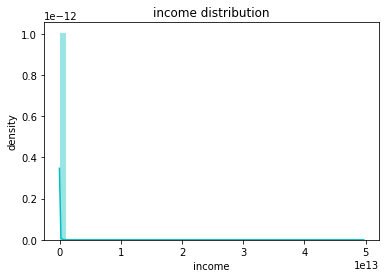

In [28]:
X_train_inc_ft = feature(X_train,'income')
X_test_inc_ft  = feature(X_test,'income')
X_train_inc_ft.plot_pdf() # highly peaked and skewed 

In [29]:
print('The income is skewed by {}'.format(X_train_inc_ft.skew)) # highly skwewed

The income is skewed by 250.7389157110026


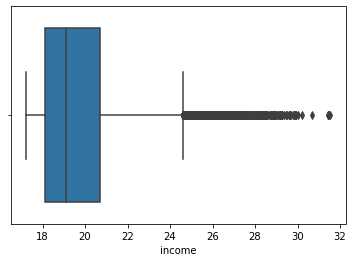

In [30]:
# reducing skew with log
log_inc = np.log(X_train['income'])
ax = X_train_inc_ft.plot_box(log_inc)

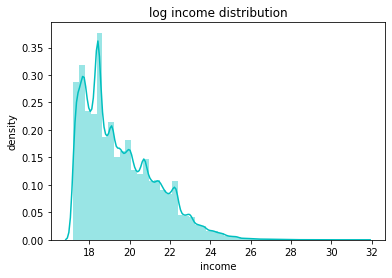

In [31]:
X_train_inc_ft.plot_pdf_mod(log_inc, 'log')

Log doesn't quite normalize the distribution. Try with boxcox

In [32]:
# boxcox 
bc_income_train = X_train_inc_ft.bc() # np array 
bc_income_test = X_test_inc_ft.bc()   # np array 

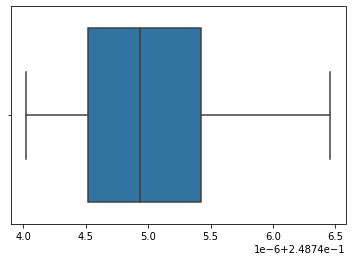

In [33]:
ax = X_train_inc_ft.plot_box(bc_income_train) # box plot of boxcox(income)

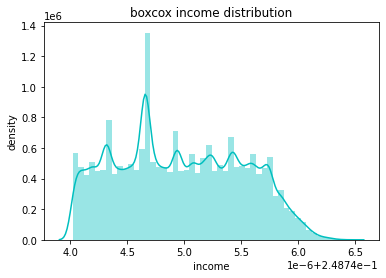

In [34]:
X_train_inc_ft.plot_pdf_mod(bc_income_train, 'boxcox')

In [35]:
# Seems good enough to save as a new engineered feature
bc_income_train_ft = feature( pd.DataFrame(bc_income_train,
                    columns=['bc_income']),'bc_income' )
bc_income_test_ft = feature( pd.DataFrame(bc_income_test,
                    columns=['bc_income']),'bc_income' )

In [36]:
bc_income_train_ft.skew

0.12718941991298097

#### 2.1.1 day,  day_of_week

In [37]:
print('The mean number of entries per day is {:.2f}.'.format(X_df.day.mean()))

The mean number of entries per day is 181.47.


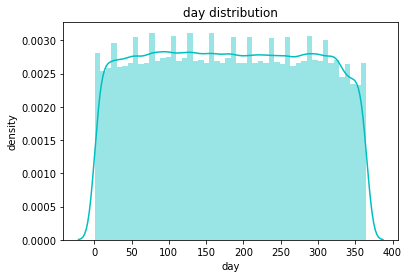

In [38]:
X_train_day_ft = feature(X_train,'day')
X_test_day_ft = feature(X_test,'day')
X_train_day_ft.plot_pdf()

In [39]:
X_train_day_ft.series.skew()


0.01044502861126917

###### Engineering day of week feature

In [40]:
def get_day_number(first_day_of_year, day):
    # day number (0 for monday, 6 for sunday) for day
    return (first_day_of_year + day - 1) % 7

In [41]:
day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows()):
    # For each data-point, we consider its year and day 
    # and calculate what day of the week (Monday, Tuesday, etc)
    # it was when the transaction happened
    # datetime.datetime(year, 1, 1).weekday() returns the first day of the year
    # using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, \
                                  get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

In [42]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows()):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, \
                                 get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

####  2.1.2 length, bc_length

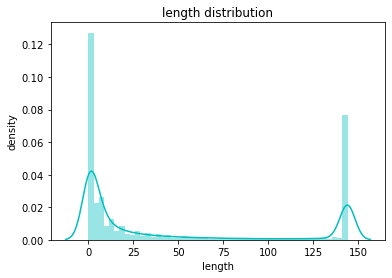

In [43]:
X_train_length_ft = feature(X_train,'length')
X_test_length_ft  = feature(X_test,'length')

X_train_length_ft.plot_pdf()

In [44]:
X_train_length_ft.skew

0.926722338090165

In [45]:
# check whether log and sqrt help the skew
X_tra_v = X_train_day_ft.vec
opsXa = np.log(np.sqrt(X_tra_v + 1e-6))
X_train_length_ft.skew, np.sqrt(X_train['length']).skew(), pd.Series(opsXa).skew()


(0.926722338090165, 0.5763394042722108, -1.7444221627158991)

In [46]:
#constructing the feature
bc_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-8))))**2)[0]
bc_length_test  = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-8))))**2)[0]

In [47]:
# new features
bc_length_train_ft = feature( pd.DataFrame(bc_length_train,
                    columns=['bc_length']),'bc_length' )
bc_length_test_ft = feature( pd.DataFrame(bc_length_test,
                    columns=['bc_length']),'bc_length' )

In [48]:
bc_length_train_ft.skew # the skew has improved

-0.18006363706286313

#### 2.1.3 weight, yeo_weight

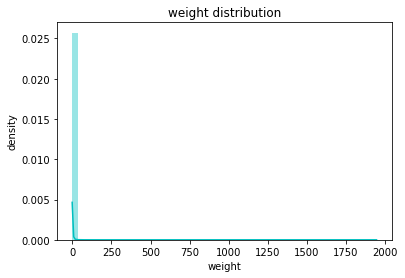

In [49]:
X_train_wt_ft = feature(X_train, 'weight')
X_test_wt_ft  = feature(X_test, 'weight')
X_train_wt_ft.plot_pdf()

In [50]:
X_train_wt_ft.skew # very skewed!

280.4573588750912

In [51]:
X_train_wt_ft.series.describe()

count    5.614630e+05
mean     5.462778e-01
std      4.606104e+00
min      3.606469e-94
25%      2.183655e-02
50%      2.500000e-01
75%      8.833250e-01
max      1.943749e+03
Name: weight, dtype: float64

In [52]:
yeo_weight_train = X_train_wt_ft.yeo()
yeo_weight_test  = X_test_wt_ft.yeo()

In [53]:
yeo_weight_train_ft = feature( pd.DataFrame(yeo_weight_train,
                    columns=['yeo_weight']),'yeo_weight' )
yeo_weight_test_ft = feature( pd.DataFrame(yeo_weight_test,
                    columns=['yeo_weight']),'yeo_weight' )

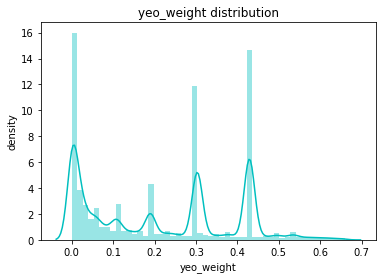

In [54]:
yeo_weight_train_ft.plot_pdf()

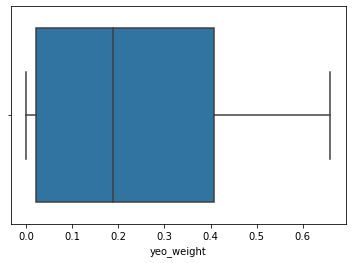

In [55]:
#plotting box plots
ax = X_train_wt_ft.plot_box(yeo_weight_train_ft.series)

#sns.boxplot(x=yeo_weight_train_ft.series)

In [56]:
yeo_weight_train_ft.skew

0.23440638184372953

#### 2.1.4 address, logbc_n_address

In [57]:
X_train_address_ft = feature(X_train,'address')
X_test_address_ft  = feature(X_test,'address')

In [58]:
X_train['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    76
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    60
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    40
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    38
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     35
                                      ..
3PRnPsknHbyxh7bmEz2JExAsnxjvHHr3mU     1
1KhDd3kCtYCg8Kjrn6Tw9hRPDr8fYoiAfq     1
1PD5cXpyNwL8SKYzcUWBEKgwVS8TPBubRQ     1
1ChWuXBqD1RDhrxA8nXv3K3ppoxt5A9GhM     1
1KasizAg9PNALw6hUZy7WKgkUcaf9DghbV     1
Name: address, Length: 533512, dtype: int64

##### Highest paid ransom address

In [59]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2013].describe()

,year,day,length,weight,count,looped,neighbors,income
count,62.0,62.000000,62.000000,62.000000,62.000000,62.0,62.000000,6.200000e+01
mean,2013.0,245.322581,10.032258,1.351558,70.483871,0.0,1.451613,6.696082e+09
std,0.0,79.087786,31.048332,0.679452,343.929784,0.0,0.693705,2.129775e+10
min,2013.0,92.000000,0.000000,0.000096,1.000000,0.0,1.000000,1.655000e+08
25%,2013.0,178.750000,0.000000,1.000000,1.000000,0.0,1.000000,1.748748e+09
50%,2013.0,253.500000,2.000000,1.000000,2.000000,0.0,1.000000,3.019705e+09
75%,2013.0,311.500000,4.000000,1.500000,3.000000,0.0,2.000000,4.891061e+09
max,2013.0,365.000000,144.000000,3.312269,2319.000000,0.0,4.000000,1.687649e+11


In [60]:
worst_culprit_address = df[df['address']=='1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']
worst_culprit_address[worst_culprit_address['year']==2014].describe()

,year,day,length,weight,count,looped,neighbors,income
count,39.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,3.900000e+01
mean,2014.0,81.153846,3.435897,1.282052,1.717949,0.051282,1.717949,1.764748e+09
std,0.0,50.954850,17.561613,0.519929,0.856821,0.320256,0.856821,3.581429e+09
min,2014.0,5.000000,0.000000,0.500000,1.000000,0.000000,1.000000,4.076000e+07
25%,2014.0,38.500000,0.000000,1.000000,1.000000,0.000000,1.000000,2.127200e+08
50%,2014.0,74.000000,0.000000,1.000000,1.000000,0.000000,1.000000,6.354000e+08
75%,2014.0,122.000000,1.000000,1.500000,2.000000,0.000000,2.000000,1.555902e+09
max,2014.0,173.000000,110.000000,2.500000,4.000000,2.000000,4.000000,2.107868e+10


In [61]:
worst_culprit_address[['length','year','day']].groupby('year')['length'].var()

year
2013    963.998942
2014    308.410256
Name: length, dtype: float64

##### Feature engineering:  logbc_n_address_train
* the number of times the address appears (log boxcox transformation applied)

In [62]:
address_cnts = X_train_address_ft.series.value_counts()
print('An address is repeated an average of {:.3f} number of times'.format(np.mean(address_cnts)))

An address is repeated an average of 1.052 number of times


In [63]:
address_cnts.skew()

27.97646128250812

In [64]:
#Since this is an extremely skewed feature let's only visualize the 1st percentile points
one_percentile = np.percentile(address_cnts, 99)
n_addresses_1perc = np.array([element for element in address_cnts if element <= one_percentile])

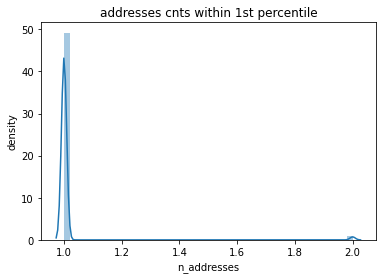

In [65]:
#checking points only within 1st percentile
plt.title('addresses cnts within 1st percentile')
sns.distplot(n_addresses_1perc)
plt.xlabel('n_addresses')
plt.ylabel('density')
plt.show()

In [66]:
dict_address_cnts = dict(X_train['address'].value_counts())
n_address = boxcox(np.array(list(dict_address_cnts.values())))[0]
# 
for index, key in tqdm(enumerate(dict_address_cnts.keys())):
    # updating the dictionary with number of times each address appears with the boxcox transformation applied to fix the skewness
    dict_address_cnts.update({key: address_cnts[index]})
 

0it [00:00, ?it/s]

In [67]:
n_address.min()

0.0

In [68]:
bc_address_n = boxcox(np.array(list(dict_address_cnts.values())))[0] # 
pd.Series(bc_address_n).skew()

5.953107169677995

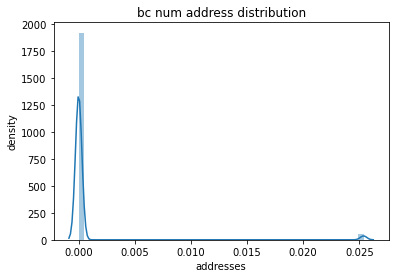

In [69]:
#plot to print distribution of n_addresses
plt.title('bc num address distribution')
sns.distplot(bc_address_n)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [70]:
bc_n_address_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set

    n_address_i = dict_address_cnts.get(X_train.loc[index]['address'])
    
    bc_n_address_train = np.append(bc_n_address_train, n_address_i)

bc_n_address_test = np.array([])
min_dict_n_address = min(list(dict_address_cnts.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    # For each address in the training set append the boxcox'd
    # number of times it appears in the training set
    try:
        #we do the same as above
        n_address_i = dict_address_cnts[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    bc_n_address_test = np.append(bc_n_address_test, n_address_i)

  0%|          | 0/561463 [00:00<?, ?it/s]

  0%|          | 0/167711 [00:00<?, ?it/s]

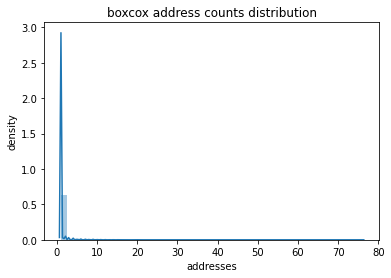

In [71]:
plt.title('boxcox address counts distribution')
sns.distplot(bc_n_address_train)
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

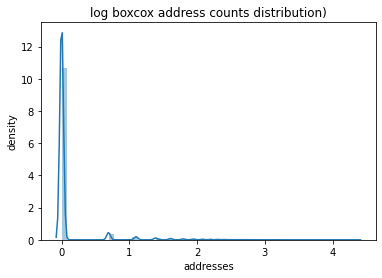

In [72]:
plt.title('log boxcox address counts distribution)')
sns.distplot(np.log(bc_n_address_train)) 
plt.xlabel('addresses')
plt.ylabel('density')
plt.show()

In [73]:
logbc_n_address_train = np.log(bc_n_address_train)
logbc_n_address_test = np.log(bc_n_address_test)

In [74]:
logbc_n_address_train_ft = feature( pd.DataFrame(logbc_n_address_train,
                    columns=['logbc_n_address']),'logbc_n_address' )
logbc_n_address_test_ft  = feature( pd.DataFrame(logbc_n_address_test,
                    columns=['logbc_n_address']),'logbc_n_address' )

In [75]:
logbc_n_address_train_ft.skew

4.734594416456778

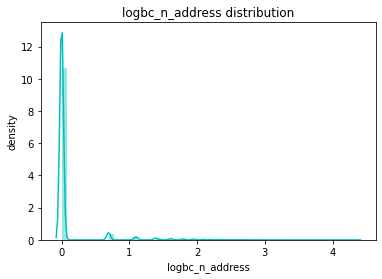

In [76]:
logbc_n_address_train_ft.plot_pdf()

#### 2.1.5 neighbors, bc_neighbors

In [77]:
X_train_neighs_ft = feature(X_train, 'neighbors')
X_test_neighs_ft  = feature(X_test, 'neighbors')

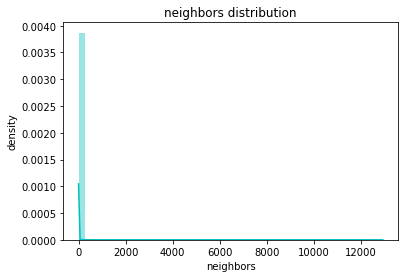

In [78]:
X_train_neighs_ft.plot_pdf()

In [79]:
X_train_neighs_ft.skew

349.670288068549

In [80]:
# apply boxcox
bc_neighbors_train = X_train_neighs_ft.bc()
bc_neighbors_test = X_test_neighs_ft.bc()

In [81]:
# generate new feature
bc_neighbors_train_ft = feature(pd.DataFrame(bc_neighbors_train,
                    columns=['bc_neighbors']),'bc_neighbors' )
bc_neighbors_test_ft = feature( pd.DataFrame(bc_neighbors_test,
                    columns=['bc_neighbors']),'bc_neighbors' )

In [82]:
bc_neighbors_train_ft.skew # skew is reduced

-0.06295930167846216

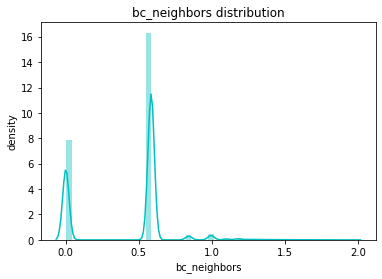

In [83]:
bc_neighbors_train_ft.plot_pdf()

#### 2.1.6 looped, sig_looped

In [84]:
X_train_lp_ft = feature(X_train, 'looped')
X_test_lp_ft  = feature(X_test, 'looped')

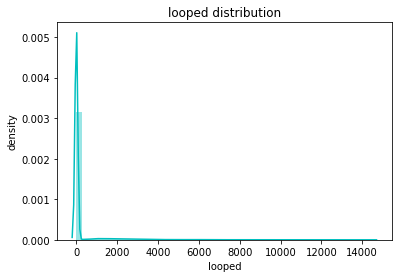

In [85]:
X_train_lp_ft.plot_pdf()

In [86]:
X_train_lp_ft.skew

5.544117274510451

In [87]:
# apply sigmoid
sig_looped_train = X_train_lp_ft.sigmoid()
sig_looped_test  = X_test_lp_ft.sigmoid()

In [88]:
# generate new feature
sig_looped_train_ft = feature(pd.DataFrame(sig_looped_train,
                    columns=['sig_looped']),'sig_looped' )
sig_looped_test_ft = feature(pd.DataFrame(sig_looped_test,
                    columns=['sig_looped']),'sig_looped' )

In [89]:
sig_looped_train_ft.skew

2.2215463159882374

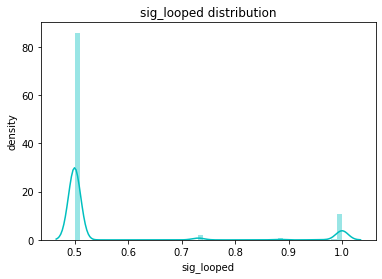

In [90]:
sig_looped_train_ft.plot_pdf()

#### 2.1.7 count, log_count

In [91]:
X_train_cnt_ft = feature(X_train,'count')
X_test_cnt_ft  = feature(X_test,'count')

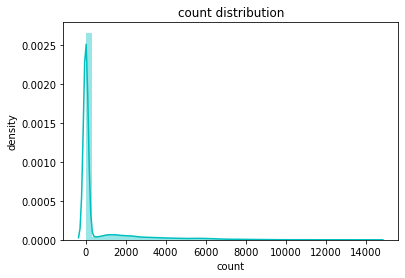

In [92]:
X_train_cnt_ft.plot_pdf()

In [93]:
X_train_cnt_ft.skew

2.9361537332298413

In [94]:
log_count_train = np.log(X_train_cnt_ft.vec + 1e-6)
log_count_test  = np.log(X_test_cnt_ft.vec + 1e-6)

In [95]:
# generate new feature
log_count_train_ft = feature( pd.DataFrame(log_count_train,
                    columns=['log_count']),'log_count' )
log_count_test_ft = feature( pd.DataFrame(log_count_test,
                    columns=['log_count']),'log_count' )

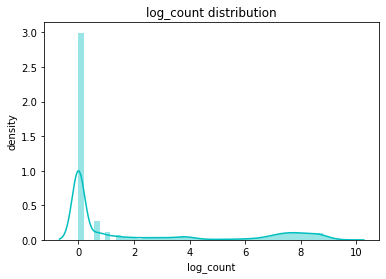

In [96]:
log_count_train_ft.plot_pdf()

In [97]:
log_count_train_ft.skew

1.0654652119731334

## 2.2 Standardizing and Encoding

* Data processing

#### 2.2.0 Inserting new features in X data

In [98]:
# original columns to get scaled for distance based classifiers
cols_orig = [ 
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income']
# new columns to get scaled for distance based classifiers
cols_new = [
    'bc_income',
    'bc_length',
    'yeo_weight',
    'logbc_n_address',
    'bc_neighbors',
    'sig_looped',
    'log_count',
    'day_of_week'
]

cols = cols_orig + cols_new
num_to_enc = 1

In [99]:
# NOTE: the vecs are all np.array types but they get converted into pd.Series typed
X_train['bc_income']       = bc_income_train_ft.vec
X_train['bc_length']       = bc_length_train_ft.vec
X_train['yeo_weight']      = yeo_weight_train_ft.vec
X_train['logbc_n_address'] = logbc_n_address_train_ft.vec
X_train['bc_neighbors']    = bc_neighbors_train_ft.vec
X_train['sig_looped']      = sig_looped_train_ft.vec
X_train['log_count']       = log_count_train_ft.vec
X_train['day_of_week']     = day_of_week_train

X_test['bc_income']        = bc_income_test_ft.vec
X_test['bc_length']        = bc_length_test_ft.vec
X_test['yeo_weight']       = yeo_weight_test_ft.vec
X_test['logbc_n_address']  = logbc_n_address_test_ft.vec
X_test['bc_neighbors']     = bc_neighbors_test_ft.vec
X_test['sig_looped']       = sig_looped_test_ft.vec
X_test['log_count']        = log_count_test_ft.vec
X_test['day_of_week']      = day_of_week_test

In [100]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [101]:
if SAVE_TEST_TRAIN == True:
    with open('derived'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

#### 2.2.1 Scaling and encoding the data

In [102]:
# cols to standardize (0 mean, unit variance)
col_names_standardize = cols[:-num_to_enc]
# cols to encode
col_names_encode = ['day_of_week']
col_names_standardize

['year',
 'day',
 'length',
 'weight',
 'count',
 'looped',
 'neighbors',
 'income',
 'bc_income',
 'bc_length',
 'yeo_weight',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count']

In [103]:
# transform the data for use in distance based modeling algorithms [logistic regression]
transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(), col_names_encode)
], remainder = 'passthrough', verbose_feature_names_out=True)

transformer.fit(X_train.drop(['address'], axis=1))

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['year', 'day', 'length', 'weight', 'count',
                                  'looped', 'neighbors', 'income', 'bc_income',
                                  'bc_length', 'yeo_weight', 'logbc_n_address',
                                  'bc_neighbors', 'sig_looped', 'log_count']),
                                ('encode', OneHotEncoder(), ['day_of_week'])])

In [104]:
# std. transformed and encoded variables (np arrays)
X_train_e = transformer.transform(X_train.drop(['address'], axis=1))
X_test_e  = transformer.transform(X_test.drop(['address'], axis=1))
# std. transformed and encoded variables (df with verbose headers)

X_train_e_df = pd.DataFrame(X_train_e,columns=transformer.get_feature_names_out())
X_test_e_df = pd.DataFrame(X_test_e,columns=transformer.get_feature_names_out())

In [105]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)

In [106]:
X_train_e_df

,standardize__year,standardize__day,standardize__length,standardize__weight,standardize__count,standardize__looped,standardize__neighbors,standardize__income,standardize__bc_income,standardize__bc_length,...,standardize__bc_neighbors,standardize__sig_looped,standardize__log_count,encode__day_of_week_0.0,encode__day_of_week_1.0,encode__day_of_week_2.0,encode__day_of_week_3.0,encode__day_of_week_4.0,encode__day_of_week_5.0,encode__day_of_week_6.0
0,-0.211527,0.792763,1.680326,-0.118137,-0.046058,-0.246207,-0.051118,-0.028709,-0.553624,0.200931,...,-1.381378,-0.394593,1.318264,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.674001,0.128802,-0.728628,-0.064323,-0.425706,-0.246207,-0.051118,-0.028146,-0.105409,-0.811871,...,-1.381378,-0.394593,-0.685371,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.211527,0.013330,-0.525055,-0.091461,-0.425706,-0.246207,-0.009305,-0.029122,-1.399961,1.313954,...,0.491485,-0.394593,-0.685371,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.211527,0.196160,-0.389339,0.098505,-0.425706,-0.246207,-0.009305,-0.026459,0.423527,1.402833,...,0.491485,-0.394593,-0.685371,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.654290,-1.728367,-0.525055,-0.117751,-0.425706,-0.246207,-0.051118,-0.028686,-0.527178,1.313954,...,-1.381378,-0.394593,-0.685371,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561458,1.559529,0.571443,1.680326,0.216763,2.917568,5.590756,-0.009305,-0.027957,-0.010136,0.200931,...,0.491485,2.697217,1.992261,0.0,0.0,1.0,0.0,0.0,0.0,0.0
561459,1.559529,-0.689122,0.798174,-0.118598,-0.425706,-0.246207,-0.009305,-0.018165,1.056186,0.723260,...,0.491485,-0.394593,-0.685371,0.0,0.0,0.0,0.0,1.0,0.0,0.0
561460,-1.539818,-0.515915,-0.558984,-0.116903,-0.425706,-0.246207,-0.051118,-0.023790,0.754322,1.250367,...,-1.381378,-0.394593,-0.685371,0.0,0.0,0.0,0.0,0.0,0.0,1.0
561461,-0.654290,1.014084,-0.660770,-0.050754,-0.424519,-0.246207,-0.009305,-0.028021,-0.040633,0.753080,...,0.491485,-0.394593,-0.344785,1.0,0.0,0.0,0.0,0.0,0.0,0.0
